## Notebook to running speed on Pi

Notebook to draft code to test running on Pi

0. Load model
1. Feature generation (measure time)
2. Make prediction (measure time)


In [2]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is

from gamutrf_feature_functions import *
from gamutrf.sample_reader import read_recording
from gamutrf.utils import parse_filename
import pickle
import time
import os


## PSD+SVM Model

In [2]:
n_per_seg = 256
t_seg = 20
model_folder = '../saved_models/'
model_file = 'SVM_PSD_'+str(n_per_seg)+'_'+str(t_seg)+'_1'
win_type = 'hamming'

## Load Model
model = pickle.load(open(model_folder+model_file, 'rb'))

## Generate features
data_folder = 'sample_data/'

for fi in os.listdir(data_folder):
    full_file = data_folder+fi
    if fi.endswith('.zst'):    # check if it is a compressed datafile
       
        freq_center, sample_rate, sample_dtype, sample_len, sample_type, sample_bits = parse_filename(full_file)
        # read sample
        samples = read_recording(full_file, sample_rate, sample_dtype, sample_len, t_seg/1e3)
        
        # get features
        start_ft = time.time()
        freqs, psds = get_PSD_from_samples(samples, sample_rate, win_type, n_per_seg)
        
        end_ft = time.time()
        print('Feature time:', end_ft-start_ft)
        
        start_pd = time.time()
        pout = model.predict(psds)
        
        end_pd = time.time()
        print('Prediction time:', end_pd-start_pd)
        
        # print average time per sample
        n_samps = pout.shape[0]
        avg_time_feat = (end_ft-start_ft)/n_samps
        avg_time_pred = (end_pd-start_pd)/n_samps
        
        print('average time for Feature Generation: {:.3}ms, Prediction: {:.3}ms'.format(avg_time_feat*1e3, avg_time_pred*1e3))

/home/kzhou/.pyenv/versions/3.8.2/envs/main/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 240, using nperseg = 240
  warnings.warn('nperseg = {0:d} is greater than input length '


Feature time: 9.693206787109375
Prediction time: 2.5399672985076904
average time for Feature Generation: 16.2ms, Prediction: 4.23ms


# NN models

In [3]:
import matplotlib.pyplot as plt 
from Torch_Models import *

In [4]:
# class VGGFC(nn.Module):
#     def __init__(self, num_classes):
#         super(VGGFC,self).__init__()
#         self.num_classes = num_classes
#         self.vggfull = models.vgg16(pretrained=True)
#         modules=list(self.vggfull.children())[:-1] # remove the fully connected layer & adaptive averaging
#         self.vggfeats=nn.Sequential(*modules)
        
#         for param in self.vggfeats.parameters():
#             param.requires_grad_(False)
        
#         self._fc = nn.Linear(25088, num_classes)
#     def forward(self, x):
#         if len(x.shape)==4:
#             x = torch.moveaxis(x,-1, 1)
#         else:
#             x = torch.moveaxis(x, -1, 0)
#         x = self.vggfeats(x)
# #         print(x.shape)
#         x = x.reshape(-1,25088)
#         x = self._fc(x)
        
#         return x

../gamutrf_feature_functions.py:35: UserWarning: Only one segment is calculated since parameter NFFT (=1024) >= signal length (=240).
  spec, _, _, _ = plt.specgram(sa, NFFT=n_per_seg, Fs=fs,


Feature time: 23.449873685836792
Prediction time: 25.701370239257812
average time for Feature Generation: 39.0ms, Prediction: 42.8ms


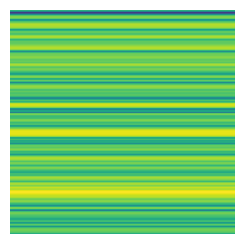

In [5]:
n_per_seg = 1024
t_seg = 20
model_folder = '../saved_models/'
model_file = 'VGGFC_SPEC_'+str(n_per_seg)+'_'+str(t_seg)
# win_type = 'hamming'

## Load Model
model = torch.load(model_folder+model_file)

## Generate features
data_folder = 'sample_data/'

for fi in os.listdir(data_folder):
    full_file = data_folder+fi
    if fi.endswith('.zst'):    # check if it is a compressed datafile
       
        freq_center, sample_rate, sample_dtype, sample_len, sample_type, sample_bits = parse_filename(full_file)
        # read sample
        
        samples = read_recording(full_file, sample_rate, sample_dtype, sample_len, t_seg/1e3)
        
        # get feature
        start_ft = time.time()
        return_array = True
        rgbs = get_specs_from_samples(samples, sample_rate, n_per_seg, return_array)
        
        end_ft = time.time()
        print('Feature time:', end_ft-start_ft)
        
        start_pd = time.time()
        feat = torch.tensor(rgbs/255).float()
        pout = model(feat)
        
        end_pd = time.time()
        print('Prediction time:', end_pd-start_pd)
        
        # print average time per sample
        n_samps = rgbs.shape[0]
        avg_time_feat = (end_ft-start_ft)/n_samps
        avg_time_pred = (end_pd-start_pd)/n_samps
        
        print('average time for Feature Generation: {:.3}ms, Prediction: {:.3}ms'.format(avg_time_feat*1e3, avg_time_pred*1e3))